### Two connected nodes for the Hopf model

In [1]:
import sys
import os
sys.path.insert(1, os.path.expanduser("~/projects/phase_amplitude_encoding/"))

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from frites.core import copnorm_nd
from hoi.core import get_mi
from mne.filter import filter_data
from mne.time_frequency.tfr import tfr_array_morlet, tfr_array_multitaper
from tqdm import tqdm

from src.models import simulate, simulate_delayed

/opt/anaconda3/envs/test_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
jax.config.update("jax_platform_name", "cpu")

#### Simulation parameters

In [4]:
Nareas = 2
ntrials = 500
fsamp = 1 / 1e-5

time = np.arange(-4, 2, 1 / fsamp)
beta = 2
Npoints = len(time)
decim = 150

C = np.array([[0, 1], [0, 0]]).T

f = 40

In [5]:
s = 16 / (2 * np.pi * f)

time_start = 0
time_end = 1
timestim = time[(time > time_start) & (time < time_end)] - (time_end - time_start) / 2
ind = np.where((time > time_start) & (time < time_end))[0]
gaussian = np.exp(-(timestim**2) / (2 * s**2))
coupling = np.zeros_like(time)
coupling[ind] = gaussian

# Coupling strength array (linearly spaced from 1 to 100)
CS = np.linspace(1, 100, ntrials)
seeds = np.random.randint(0, 100000, ntrials)

In [6]:
simulate_loop = jax.vmap(
    simulate, in_axes=(None, 0, None, None, None, None, None, None, 0, None, None, None)
)

In [7]:
coupling = CS[:, None] * coupling

In [8]:
out = simulate_loop(
    C,
    1 * coupling,
    40,
    -3,
    fsamp,
    beta,
    Npoints,
    None,
    seeds,
    "cpu",
    decim,
    "both",
)

In [9]:
data = xr.DataArray(
    np.stack(out),
    dims=("trials", "roi", "times"),
    coords=(range(ntrials), ["x", "y"], time[::decim]),
)

In [10]:
"""
fig = plt.figure(figsize=(8 / 2.54, 5 / 2.54))
ax = plt.subplot(111)
for i in range(Nareas):
    plt.plot(z_data[-1].times, z_data[-1].values[i].real + (i * 3))
plt.xlabel("Time [s]", fontsize=12)
# plt.legend(["Sender", "Receiver"], frameon=False, fontsize=12)
plt.xlim(-2, 2)
[ax.spines[key].set_visible(False) for key in ["top", "right"]]
plt.savefig("figures/hopf_time_series.png", bbox_inches="tight")
""";

In [11]:
mi_fcn = get_mi("gc")

mi_fcn_time = jax.vmap(mi_fcn, in_axes=(2, 2, None, None))

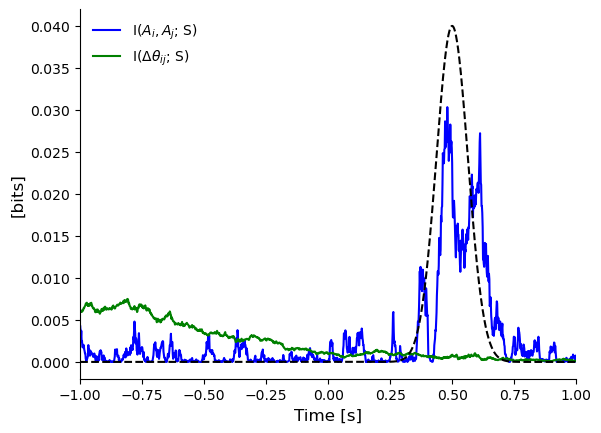

In [12]:
labels = np.tile(np.expand_dims(CS, 1), data.sizes["times"])
z = data[:, 0] * np.conj(data[:, 1])
A = np.abs(z).values
dphi = np.unwrap(np.angle(z))

I_S_R1 = mi_fcn_time(A[None], labels[None], False, True)
I_S_R2 = mi_fcn_time(dphi[None], labels[None], False, True)

ax = plt.subplot(111)
plt.plot(data.times, I_S_R1, "b")
plt.plot(data.times, I_S_R2, "g")
plt.plot(
    time[(time >= -1) * (time <= 1)],
    coupling[-1, (time >= -1) * (time <= 1)] / 10000 * 4,
    "k--",
)

plt.legend(
    [
        r"I($A_{i}, A_{j}$; S)",
        r"I($\Delta\theta_{ij}$; S)",
    ],
    frameon=False,
)

plt.xlabel("Time [s]", fontsize=12)
plt.ylabel("[bits]", fontsize=12)
[ax.spines[key].set_visible(False) for key in ["top", "right"]]
plt.xlim(-1, 1)
plt.savefig("figures/sample_encoding_evoked_potential.png", bbox_inches="tight")

In [13]:
z = data.isel(roi=0) * np.conj(data.isel(roi=1))
A = np.abs(z).values
dphi = np.unwrap(np.angle(z))

In [14]:
labels = np.tile(np.expand_dims(CS, 1), data.sizes["times"])

In [ ]:
plt.figure(figsize=(6, 6), dpi=150)
ax = plt.subplot(111)

mi_fcn = get_mi("gc")

mi_fcn_time = jax.vmap(mi_fcn, in_axes=(2, 2, None, None))


mv = np.stack((A, dphi), axis=0)


plt.plot(data[-1].times, mi_fcn_time(mv, labels[None], False, True))
plt.plot(data[-1].times, mi_fcn_time(A[None], labels[None], False, True))
plt.plot(data[-1].times, mi_fcn_time(dphi[None], labels[None], False, True))

plt.legend(
    [
        r"I($A_{ij}, \Delta\theta_{ij}$; S)",
        r"I($A_{ij}$; S)",
        r"I($\Delta\theta_{ij}$; S)",
    ],
    frameon=False,
)

plt.xlabel("Time [s]", fontsize=12)
plt.ylabel("[bits]", fontsize=12)
[ax.spines[key].set_visible(False) for key in ["top", "right"]]

In [ ]:
decim


#### Run a batch of simulations

In [ ]:
I_S_R1 = []
I_S_R2 = []
I_S_R1_R2 = []

for _ in tqdm(range(100)):

    seeds = np.random.randint(0, 100000, ntrials)

    out = simulate_loop(
        1 * C,
        coupling,
        40,
        -3,
        fsamp,
        beta,
        Npoints,
        None,
        seeds,
        "cpu",
        decim,
        "both",
    )

    stim = np.arange(ntrials)
    data = xr.DataArray(
        np.stack(out),
        dims=("trials", "roi", "times"),
        coords=(stim, ["x", "y"], time[::decim]),
    ).sel(times=slice(-2, 2))

    labels = np.tile(np.expand_dims(CS, 1), data.sizes["times"])
    z = data[:, 0] * np.conj(data[:, 1])
    A = np.abs(z).values
    dphi = np.unwrap(np.angle(z))
    mv = np.stack((A, dphi), axis=0)

    I_S_R1 += [mi_fcn_time(A[None], labels[None], False, True)]
    I_S_R2 += [mi_fcn_time(dphi[None], labels[None], False, True)]
    I_S_R1_R2 += [mi_fcn_time(mv, labels[None], False, True)]

In [ ]:
plt.figure(figsize=(8 / 2.54, 8 / 2.54))
ax = plt.subplot(111)
plt.plot(data.times, np.mean(I_S_R1, 0), "orange")
plt.plot(data.times, np.mean(I_S_R2, 0), "g")
plt.plot(data.times, np.mean(I_S_R1_R2, 0), "b")

plt.plot(
    time[(time >= 0) * (time <= 1)],
    coupling[-1, (time >= 0) * (time <= 1)] / 10000 * 4,
    "k--",
)

plt.legend(
    [
        "I($A_{i}A_{j}$; S)",
        r"I($\Delta\theta_{ij}$; S)",
        r"I($\Delta\theta_{ij}, A_{i}A_{j}$; S)",
        
        "g(t)",
    ],
    frameon=False,
)

plt.xlabel("Time [s]", fontsize=12)
plt.ylabel("[bits]", fontsize=12)
[ax.spines[key].set_visible(False) for key in ["top", "right"]]
plt.xlim(0, 1)
plt.savefig("figures/sample_encoding_evoked_potential.pdf", bbox_inches="tight")

In [ ]:
I_S_R1 = np.mean(I_S_R1, 0)
I_S_R2 = np.mean(I_S_R2, 0)
I_S_R1_R2 = np.mean(I_S_R1_R2, 0)

In [ ]:
red = np.minimum(I_S_R2, I_S_R1)
syn = I_S_R1_R2 - np.maximum(I_S_R2, I_S_R1)

In [ ]:
plt.figure(figsize=(15 / 2.54, 5 / 2.54))

ax = plt.subplot(121)
plt.plot(data.times, red)
plt.plot(data.times, syn)

plt.legend([r"Red[$\Delta\theta_{ij}, A_{i}A_{j}$]", r"Syn[$\Delta\theta_{ij}, A_{i}A_{j}$]"], frameon=False)
plt.xlim(0, 1)
plt.ylim(-0.0001, 0.01)
[ax.spines[key].set_visible(False) for key in ["top", "right"]]
plt.ylabel("[bits]", fontsize=12)

ax = plt.subplot(122)
plt.plot(data.times, I_S_R1 - syn)
plt.plot(data.times, I_S_R2 - syn)
plt.ylim(-0.0001, 0.004)
#ax.set_yticklabels([])
plt.legend([r"Un[$A_{i}A_{j}$]", r"Un[$\Delta\theta_{ij}$]"], frameon=False)
[ax.spines[key].set_visible(False) for key in ["top", "right"]]


plt.subplots_adjust(wspace=.35)
plt.xlabel("Time [s]", fontsize=12)

plt.savefig("figures/red_syn_amp_vs_phase.pdf", bbox_inches="tight")